# **Recurrent Neural Network (RNN)**

핸즈 온 머신러닝 
*   15장 RNN과 CNN을 사용해 시퀀스 처리하기 
*   16장 RNN과 어텐션을 사용한 자연어 처리 

참고자료 

https://gongu.copyright.or.kr/ 

https://nbviewer.jupyter.org/github/rickiepark/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb 

https://nbviewer.jupyter.org/github/rickiepark/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb 

https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/tree/master/6.CHATBOT 

https://www.tensorflow.org/text/tutorials/transformer 

In [ ]:
#!pip uninstall -q tensorflow tensorflow-estimator tensorboard tensorflow-probability 
#!pip install -q tensorflow==2.1.0 

In [1]:
import tensorflow as tf 
import tensorflow.keras as keras 
import numpy as np

In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.2



## Data Preprocessing 

In [3]:
# fill code
with open('C:/Users/yujk3/Desktop/AI_dataset/HW5/merged.txt', 'r', encoding='utf-8') as f:
    merged_text = f.read()

In [4]:
len(merged_text)

77471

In [5]:
merged_text[-20:]

'. 희로애락을 지성으로 근고하옵니다.'

모든 글자를 정수로 Encoding 

Keras의 Tokenizer 

1부터 시작해서 고유한 글자 개수(1401)까지 만듦 

In [6]:
# lower인자 : 영어의 경우 대문자 -> 소문자(한국어를 사용하는 경우 false로 하는 경우가 많음)
#             한글 같은 경우 해당 인자를 true로 하면 글자가 초정/중성/종성으로 분해됨
# char_level인자 : 글자 단위로 보겠다
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, char_level=True)   # fill code
tokenizer.fit_on_texts(merged_text)   # fill code

In [7]:
# 총 사전의 size
len(tokenizer.word_index)

875

In [8]:
# 자연어 문자 -> 정수(사전의 index) 변환
tokenizer.texts_to_sequences(['사소저는 덕행과 용모가 출중합니다.'])

[[12, 39, 94, 13, 1, 196, 103, 75, 1, 216, 42, 8, 1, 317, 113, 233, 17, 6, 7]]

In [9]:
# fill code
tokenizer.sequences_to_texts([[12, 39, 94, 13, 1, 196, 103, 75, 1, 216, 42, 8, 1, 317, 113, 233, 17, 6, 7]])

['사 소 저 는   덕 행 과   용 모 가   출 중 합 니 다 .']

max_id : 고유 글자 개수 (1,401개) 

dataset_size: 전체 글자 개수 (176,598개)

In [10]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [11]:
print(max_id)
print(dataset_size)

875
77471


전체 텍스트를 Encoding해서 각 글자를 ID로 나타내기 

(0부터 시작하기 위해서 1 빼기) 

In [12]:
[encoded] = np.array(tokenizer.texts_to_sequences([merged_text])) - 1

텍스트의 처음 90%를 훈련 세트로 사용 

이 텍스트 세트에서 한 번에 한 글자씩 반환하는 tf.data.Dataset 객체 만들기 

In [13]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

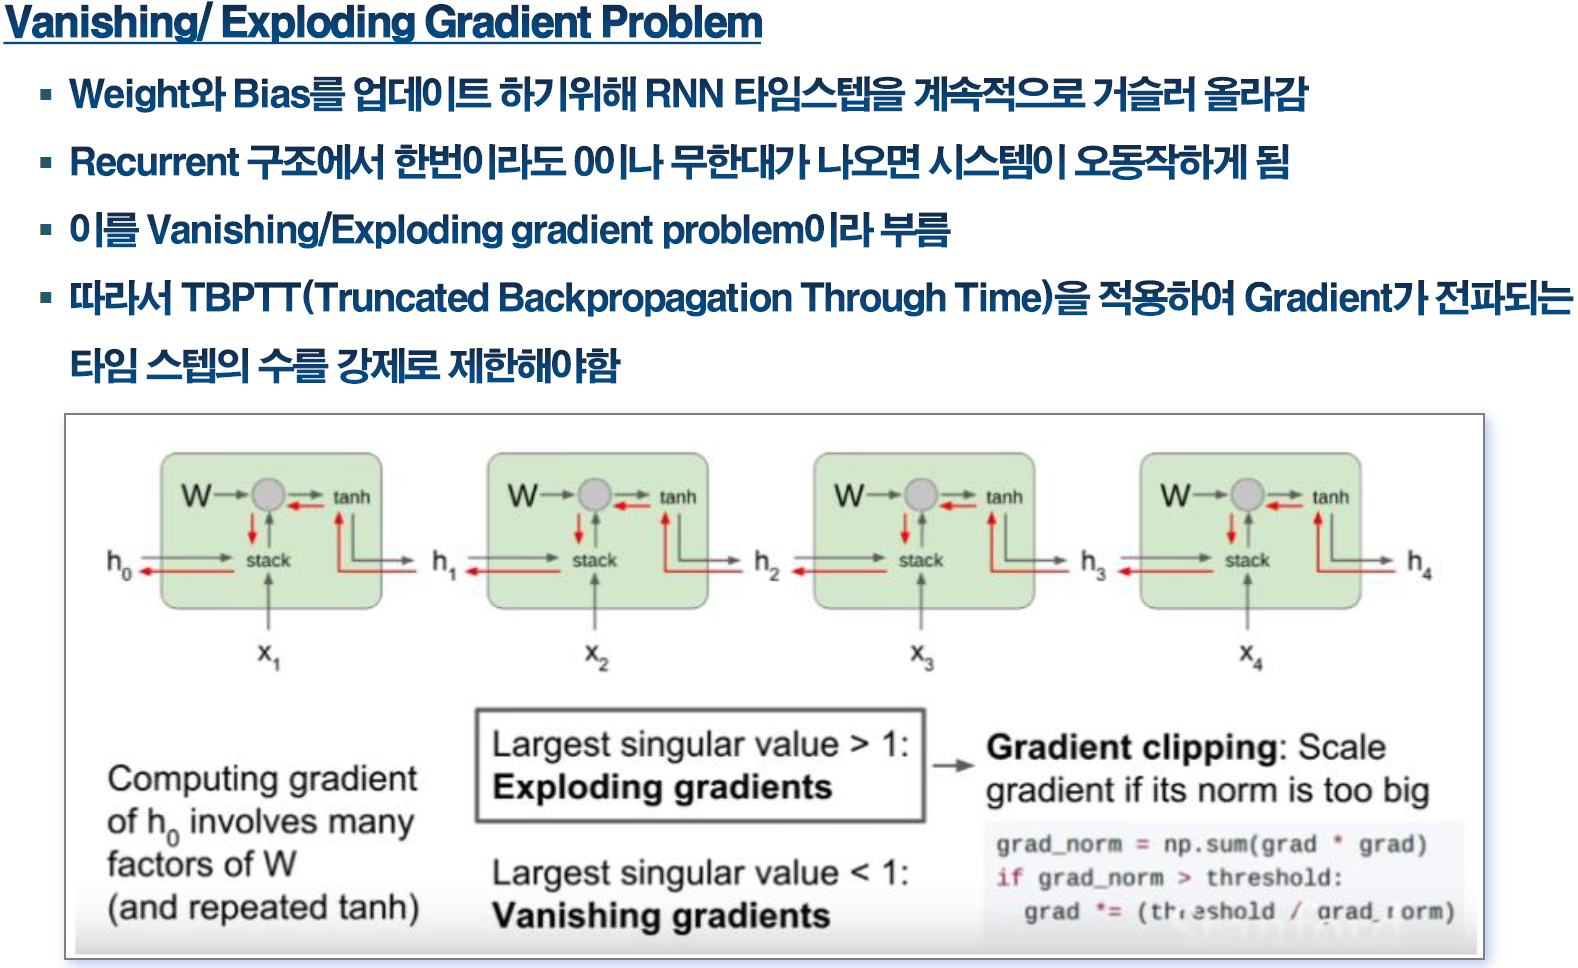

[18강] RNN.(2) - LSTM.GRU.pdf p.25 

window() method를 사용해서 여러 텍스트 window로 변환 

100(모델이 보는 데이터) + 1(모델이 맞추어야 하는 데이터) 

RNN은 이 부분 문자열 길이만큼만 Back-propagation 

Truncated BackPropagation Through Time(TBPTT) 

In [14]:
n_steps = 100
window_length = n_steps + 1 # target <= input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

모델의 실제 입력으로 사용되는 tensor 형태로 변환 

window마다 batch(window_length)를 호출 

In [15]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

One-hot encoding 

In [18]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

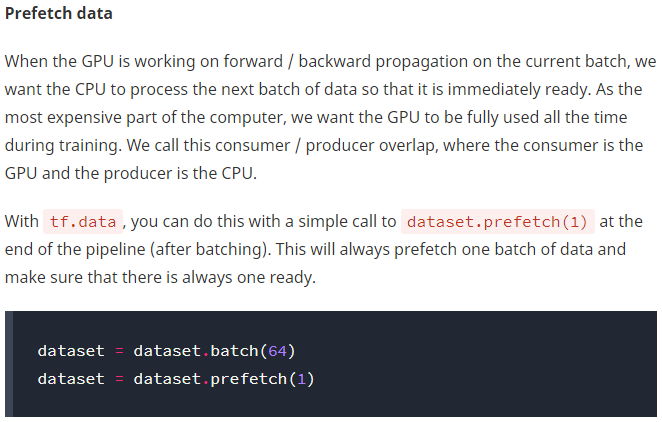

https://cs230.stanford.edu/blog/datapipeline/#best-practices 

In [19]:
dataset = dataset.prefetch(1)

(batch_size, n_steps, max_id) (batch_size, n_steps) 

In [20]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 875) (32, 100)


## Korean CharNet Model  

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
    tf.keras.layers.LSTM(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [24]:
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
2178/2178 [==============================] - 1282s 587ms/step - loss: 3.9631 - accuracy: 0.2796
Epoch 2/10
2178/2178 [==============================] - 1332s 611ms/step - loss: 3.1650 - accuracy: 0.3673
Epoch 3/10
2178/2178 [==============================] - 1313s 603ms/step - loss: 2.7693 - accuracy: 0.4215
Epoch 4/10
2178/2178 [==============================] - 1341s 616ms/step - loss: 2.4468 - accuracy: 0.4691
Epoch 5/10
2178/2178 [==============================] - 1340s 615ms/step - loss: 2.1871 - accuracy: 0.5109
Epoch 6/10
2178/2178 [==============================] - 1338s 614ms/step - loss: 1.9845 - accuracy: 0.5460
Epoch 7/10
2178/2178 [==============================] - 1360s 624ms/step - loss: 1.8224 - accuracy: 0.5752
Epoch 8/10
2178/2178 [==============================] - 1350s 620ms/step - loss: 1.6919 - accuracy: 0.6000
Epoch 9/10
2178/2178 [==============================] - 1345s 617ms/step - loss: 1.5857 - accuracy: 0.6206
Epoch 10/10
2178/2178 [==============

In [25]:
# https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format 
# Save the entire model as a SavedModel.
model.save('C:/Users/yujk3/Desktop/AI_dataset/HW5/Korean_CharNet2') 

INFO:tensorflow:Assets written to: C:/Users/yujk3/Desktop/AI_dataset/HW5/Korean_CharNet2\assets


INFO:tensorflow:Assets written to: C:/Users/yujk3/Desktop/AI_dataset/HW5/Korean_CharNet2\assets


↑ 위의 작업:

모델 훈련 + 훈련한 후 가중치 등 모델에 대한 정보를 저장하는 작업

In [ ]:
# 압축파일의 압축을 푸는 작업
#!unzip Korean_CharNet.zip

In [26]:
new_model = tf.keras.models.load_model('C:/Users/yujk3/Desktop/AI_dataset/HW5/Korean_CharNet2')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         514048    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 875)         112875    
Total params: 758,507
Trainable params: 758,507
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = new_model

모델 사용하기

모델에 새로운 텍스트 입력을 위한 전처리 

In [28]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [36]:
X_new = preprocess(["그 화법이 정묘하여 관음보살과 동자가 살아서 움직일 듯이 보였"])
# Y_pred = model.predict_classes(X_new)
Y_pred = model.predict(X_new)
classes_X = np.argmax(Y_pred, axis=1)
# tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char
tokenizer.sequences_to_texts(classes_X + 1)[0][-1] # 1st sentence, last char

' '

In [32]:
tf.random.set_seed(42)
# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/random/categorical 
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=5).numpy()

array([[0, 1, 0, 2, 1]], dtype=int64)

다음 글자를 온도에 따라 선택 

온도가 매우 높으면 모든 글자가 동일한 확률을 가짐 

In [33]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [37]:
tf.random.set_seed(42)

next_char("그 화법이 정묘하여 관음보살과 동자가 살아서 움직일 듯이 보였", temperature=1)

'다'

In [38]:
next_char("그 화법이 정묘하여 관음보살과 동자가 살아서 움직일 듯이 보였", temperature=0.1)

'다'

다음 글자를 반복적으로 얻어서 텍스트에 추가 

In [39]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [40]:
tf.random.set_seed(42)

print(complete_text("내", temperature=0.1))

내 사람을 보내서 통곡하였다.사씨는 그 여자의 투기 한림이 없어서 간장하였다.그 때 교씨는 


In [41]:
print(complete_text("내", temperature=0.25))

내 사람을 보내서 통곡하였다.그 매파가 유한림의 눈물을 뿌리고 강가에 몸을 붙졌다.유연 이 


In [42]:
print(complete_text("내", temperature=0.5))

내 이 있을 뿐 아니라 하늘이 도로 귀양보이라고 지냈다. 그러나 이튿날 새벽에 누 밑에서 소


In [43]:
print(complete_text("내", temperature=0.75))

내보시고 지금을 사씨 고하게 되었으므로 한탄할 죄름다.아마 부인의 반명을 받아 온 사람이었다


In [44]:
print(complete_text("내", temperature=1))

내쫓아서 사양하고다. 팔자와 조실향 고하니 나는 교씨 소식을 듣고 본별부 하여 과 두 인부와


In [45]:
print(complete_text("내", temperature=2))

내지가.알아내자보함의 보파다가 장요 땅지난 몸을 자는야생씨에게 또 죽은택것습이다.거만하소사서


In [46]:
print(complete_text("점", temperature=0.2))

점에 이곳에 와서 암자가 퇴락하여 금년의 정재를 얻어서 간곡하였다.사씨는 십랑과 공모하고 현


In [47]:
print(complete_text("점", temperature=0.25))

점에 이곳에 와서 암자가 퇴락하여 금년의 정재를 얻어서 중수하느라고 소승이 쓴 글을 보고 있


In [48]:
print(complete_text("점", temperature=0.5))

점을 보내며 목을 찾았다. 그러다. 유한림이 이 소생을 하면서 교씨하였다.유한림이 비로소 우


In [49]:
print(complete_text("점", temperature=0.75))

점을 밝으면 역시 앉아 있어도 기쁨이 말이 어냥 두부가서 태수 같고 불정인 줄 알았다가 이 


In [50]:
print(complete_text("점", temperature=1))

점 침노하고 적에서 들둔한 일에는 비복에게 민망한 후통하이 놀라운 점애 사었을데 엄승상의 불


In [51]:
print(complete_text("점", temperature=2))

점신은크로 냉서함과 비복에 있리셨던 십관처가 흘렀하 .소세히 매창제 꼬은, 냉심을 벗나났으면


In [52]:
print(complete_text("그건", temperature=0.25))

그건 그 여자가 있는 한림을 찾아서 보통 기금이었다. 그 화상은 본디 인연의 몸을 지로 여기의
